In [1]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os

########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 5 # the lower limit of qubits for the circuit
steps= 1 #jump in qubit numbers
name_of_algo='vqe'

In [2]:
emulator = Aer.get_backend('aer_simulator_density_matrix')
ghz = supermarq.vqe_proxy.VQEProxy(3,1)
ghz_circuit = ghz.qiskit_circuit()
#ghz_circuit.draw()
qc = transpile(ghz_circuit, emulator)
job = execute(qc, emulator, shots=8192, memory=True)
data=job.result()
job.status()
data = job.result()
counts = job.result().get_counts()
score = ghz.score(counts)
print(score)

0.9968923981082559


In [3]:
emulator = Aer.get_backend('aer_simulator_density_matrix')
ghz = supermarq.vqe_proxy.VQEProxy(3,2)
ghz_circuit = ghz.qiskit_circuit()
#ghz_circuit.draw()
qc = transpile(ghz_circuit, emulator)
job = execute(qc, emulator, shots=8192, memory=True)
data=job.result()
job.status()
data = job.result()
counts = job.result().get_counts()
score = ghz.score(counts)
print(score)

0.9960407009114755


In [4]:
emulator = Aer.get_backend('aer_simulator_density_matrix')
ghz = supermarq.vqe_proxy.VQEProxy(3)
ghz_circuit = ghz.qiskit_circuit()
#ghz_circuit.draw()
qc = transpile(ghz_circuit, emulator)
job = execute(qc, emulator, shots=8192, memory=True)
data=job.result()
job.status()
data = job.result()
counts = job.result().get_counts()
score = ghz.score(counts)
print(score)

0.9973363765257655


In [5]:
emulator = Aer.get_backend('aer_simulator_density_matrix')
ghz = supermarq.vqe_proxy.VQEProxy(3,3)
ghz_circuit = ghz.qiskit_circuit()
#ghz_circuit.draw()
qc = transpile(ghz_circuit, emulator)
job = execute(qc, emulator, shots=8192, memory=True)
data=job.result()
job.status()
data = job.result()
counts = job.result().get_counts()
score = ghz.score(counts)
print(score)

0.9996922032443671


In [6]:
all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
import random; selected_fakes = random.sample(all_fakes, f)
selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list

[qiskit.providers.fake_provider.backends.cairo.fake_cairo.FakeCairoV2,
 qiskit.providers.fake_provider.backends.manila.fake_manila.FakeManilaV2,
 qiskit.providers.fake_provider.backends.santiago.fake_santiago.FakeSantiagoV2,
 qiskit.providers.fake_provider.backends.mumbai.fake_mumbai.FakeMumbaiV2,
 qiskit.providers.fake_provider.backends.sherbrooke.fake_sherbrooke.FakeSherbrooke]

In [7]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.vqe_proxy.VQEProxy(i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    #print(circuit.draw())

-------------------------- vqe3 ---------------------------
-------------------------- vqe4 ---------------------------


In [8]:
benchmark_features = {}
#for benchmark, label in benchmarks:
#    benchmark_features[label] = [
#        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
#        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
#        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
#        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
#        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
#        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
#print(benchmark_features)

In [9]:
jobs =[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("------------------------BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        for i in range(0,5):
            job = backend().run(circuit, shots=1000)
            result=job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            score_list.append(score)
        score = np.mean(score_list) 
        sd = np.std(score_list)
        print(label," :: ",score,"                       SD :: ",sd)
        #counts=job.result(0).count()
        jobs.append((label,benchmark,backend,job,score,sd))
#jobs

=============SCORES OF ALL THE CIRCUITS=============
------------------------BACKEND-NAME ::  fake_cairo
vqe3  ::  0.9648499327704455                        SD ::  0.01003169506827288
vqe4  ::  0.9666648226846262                        SD ::  0.00945147818934915
------------------------BACKEND-NAME ::  fake_manila
vqe3  ::  0.8804328039114153                        SD ::  0.009109748746544931
vqe4  ::  0.896708697999866                        SD ::  0.007728762004345746
------------------------BACKEND-NAME ::  fake_santiago
vqe3  ::  0.9636326324796881                        SD ::  0.00805972574676114
vqe4  ::  0.9684880417982231                        SD ::  0.006477657441094145
------------------------BACKEND-NAME ::  fake_mumbai
vqe3  ::  0.93971003546133                        SD ::  0.002691436575564397
vqe4  ::  0.9296851828371014                        SD ::  0.009405658831371816
------------------------BACKEND-NAME ::  fake_sherbrooke
vqe3  ::  0.9593985445118373               

In [10]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

USED BACKEND:: fake_cairo ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9648499327704455


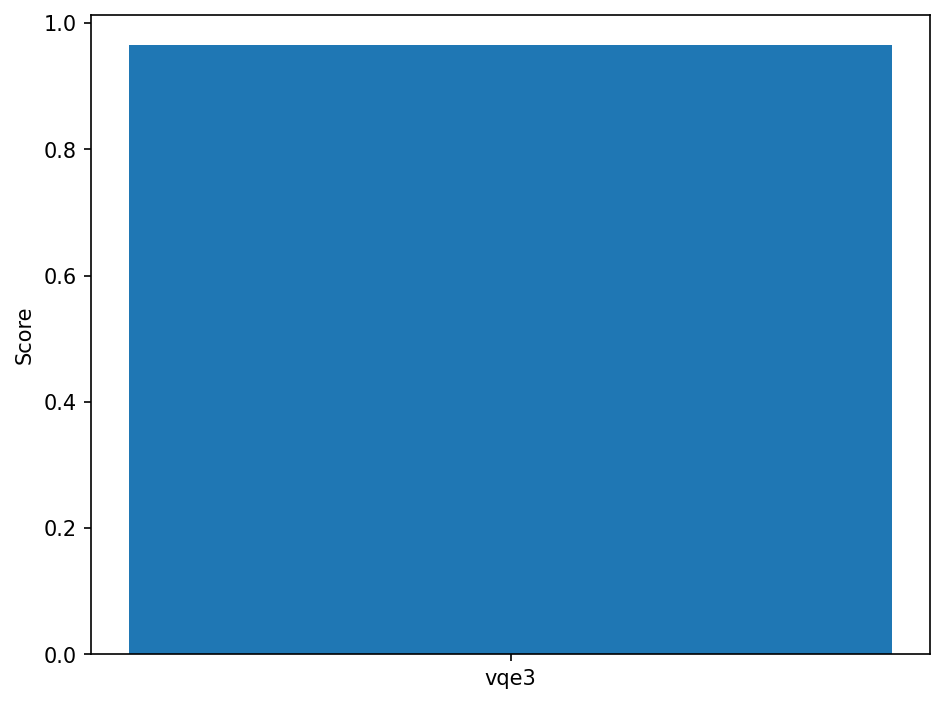

-----------------------------------------------------------
USED BACKEND:: fake_cairo ; CIRCUIT_NAME: vqe4 ; SCORE = 0.9666648226846262


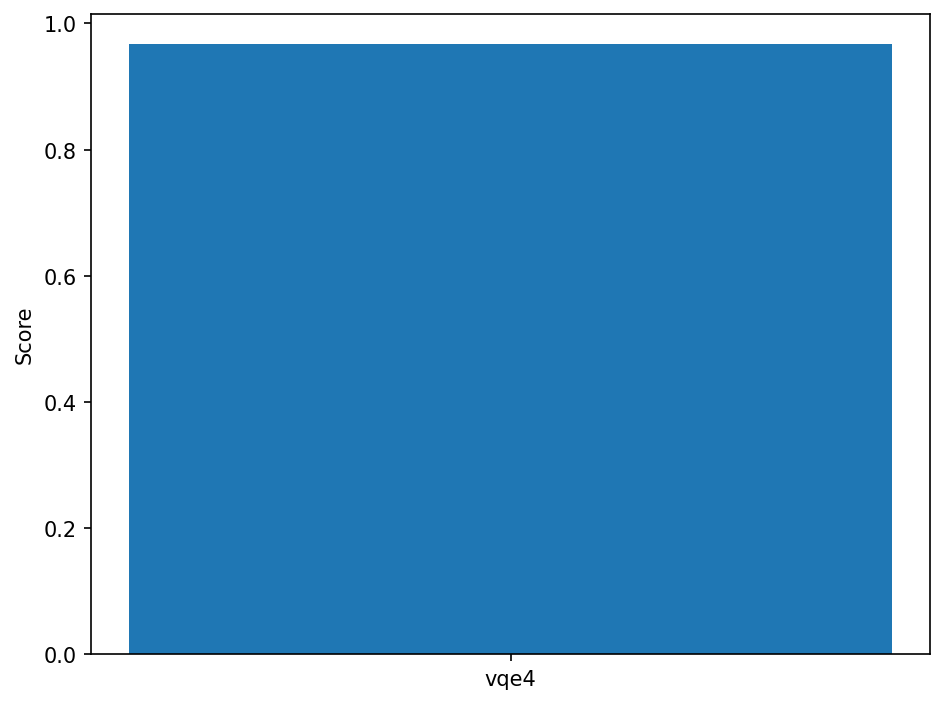

-----------------------------------------------------------
USED BACKEND:: fake_manila ; CIRCUIT_NAME: vqe3 ; SCORE = 0.8804328039114153


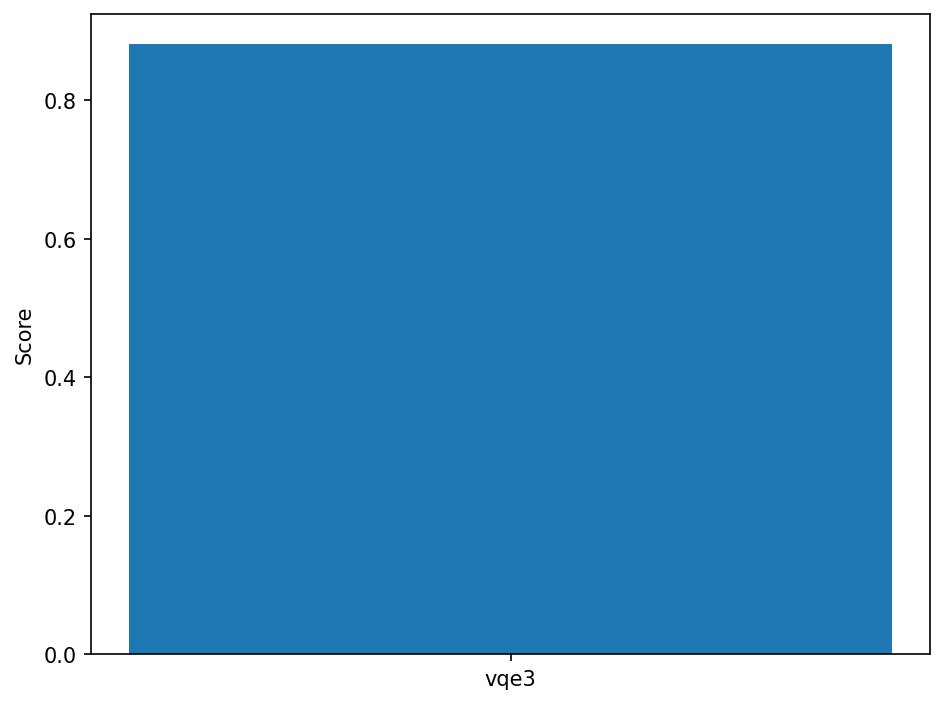

-----------------------------------------------------------
USED BACKEND:: fake_manila ; CIRCUIT_NAME: vqe4 ; SCORE = 0.896708697999866


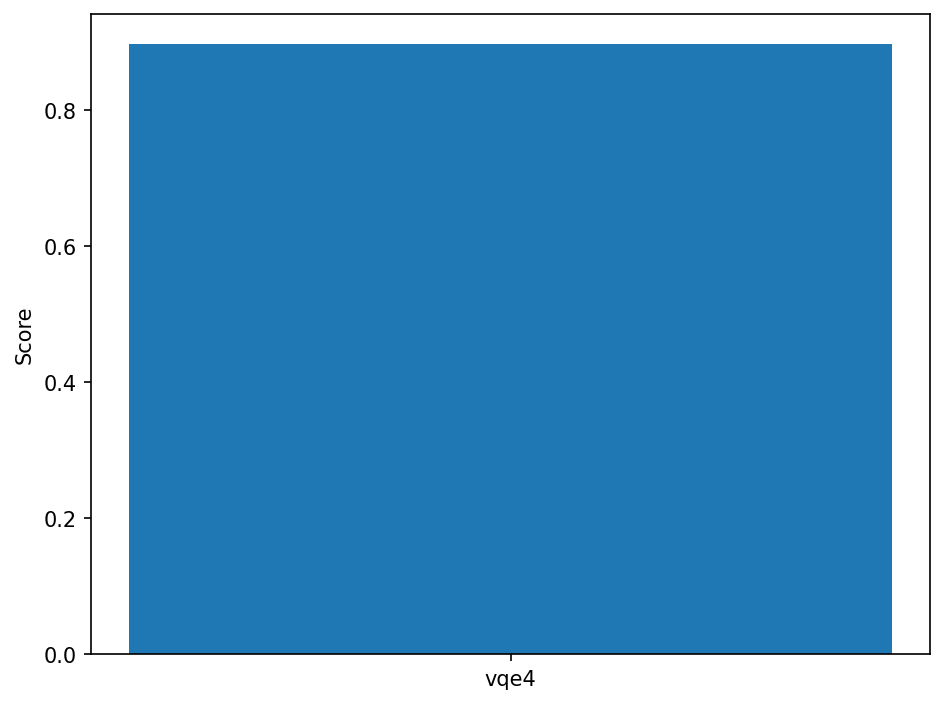

-----------------------------------------------------------
USED BACKEND:: fake_santiago ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9636326324796881


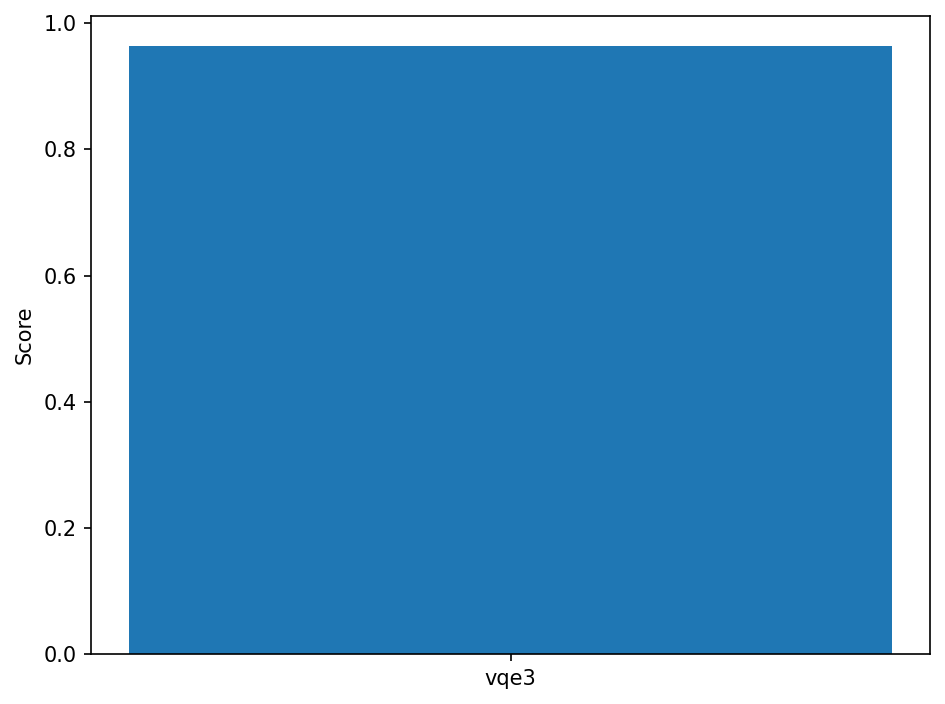

-----------------------------------------------------------
USED BACKEND:: fake_santiago ; CIRCUIT_NAME: vqe4 ; SCORE = 0.9684880417982231


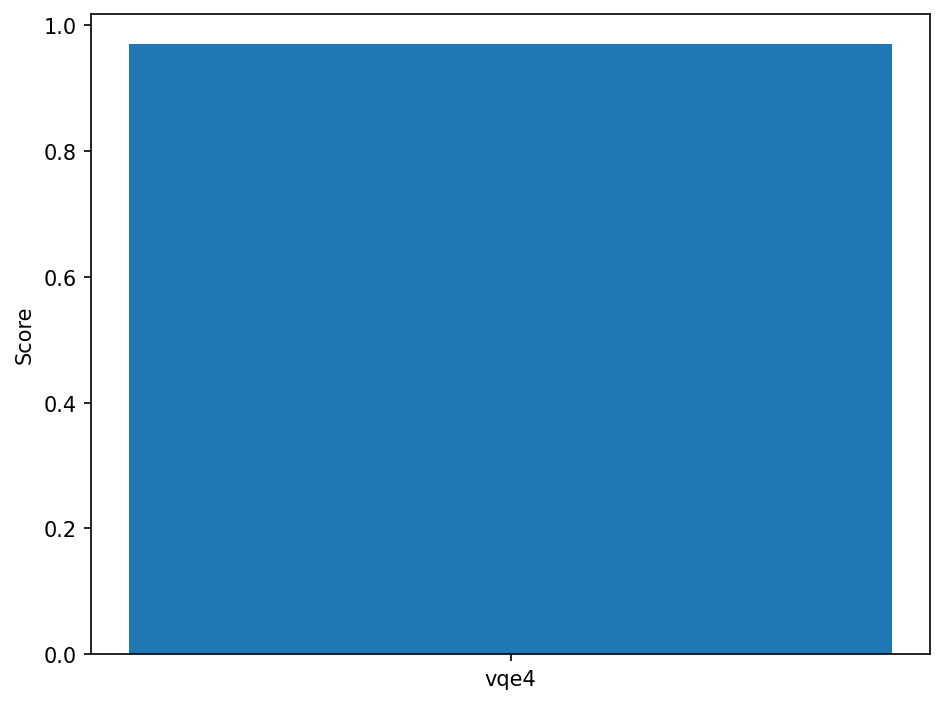

-----------------------------------------------------------
USED BACKEND:: fake_mumbai ; CIRCUIT_NAME: vqe3 ; SCORE = 0.93971003546133


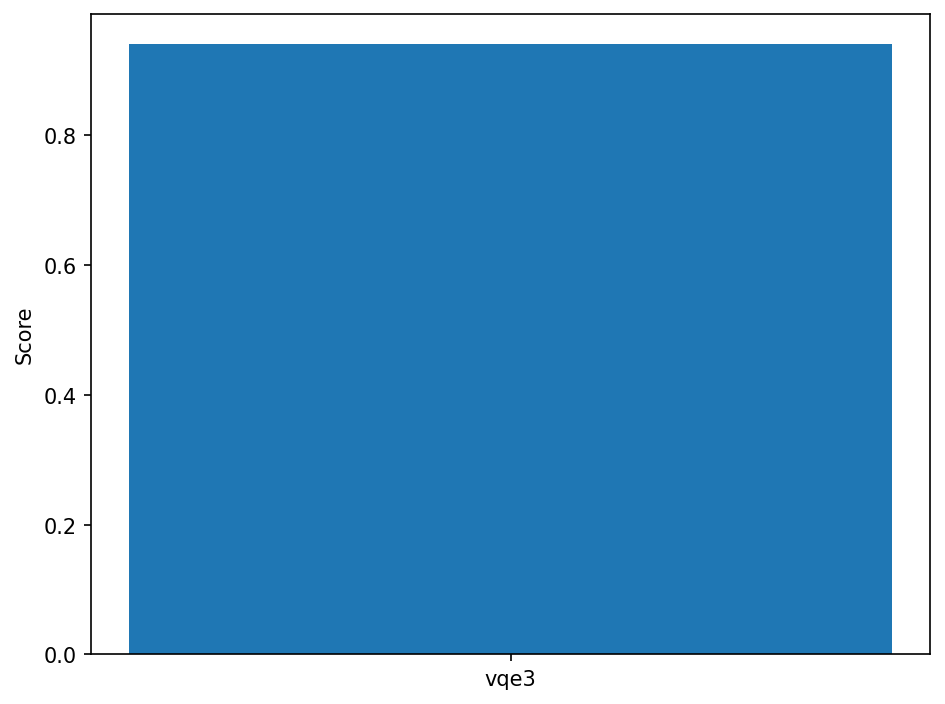

-----------------------------------------------------------
USED BACKEND:: fake_mumbai ; CIRCUIT_NAME: vqe4 ; SCORE = 0.9296851828371014


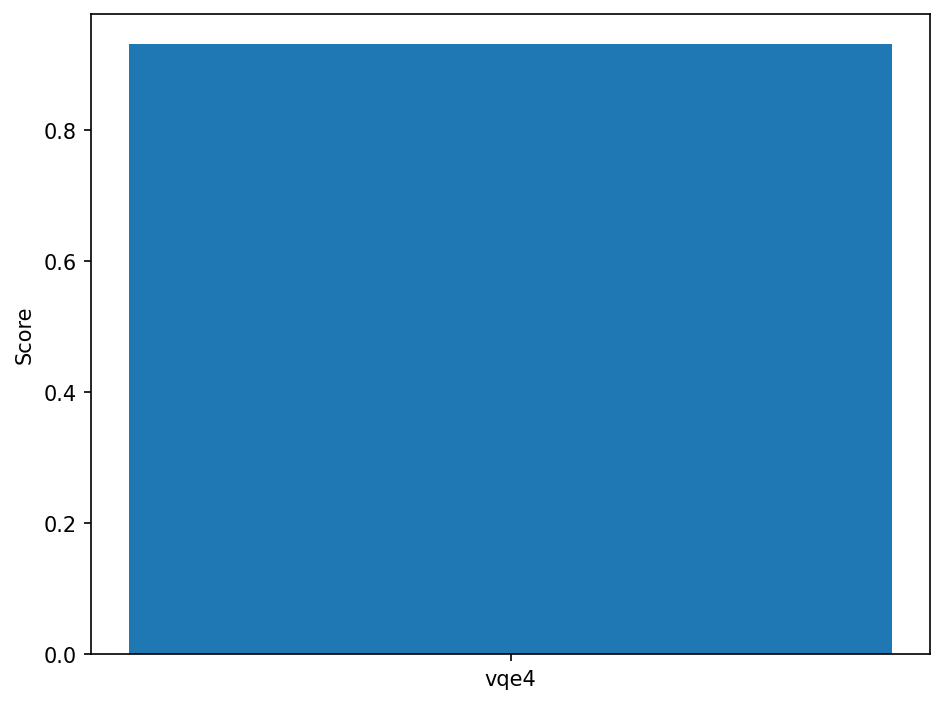

-----------------------------------------------------------
USED BACKEND:: fake_sherbrooke ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9593985445118373


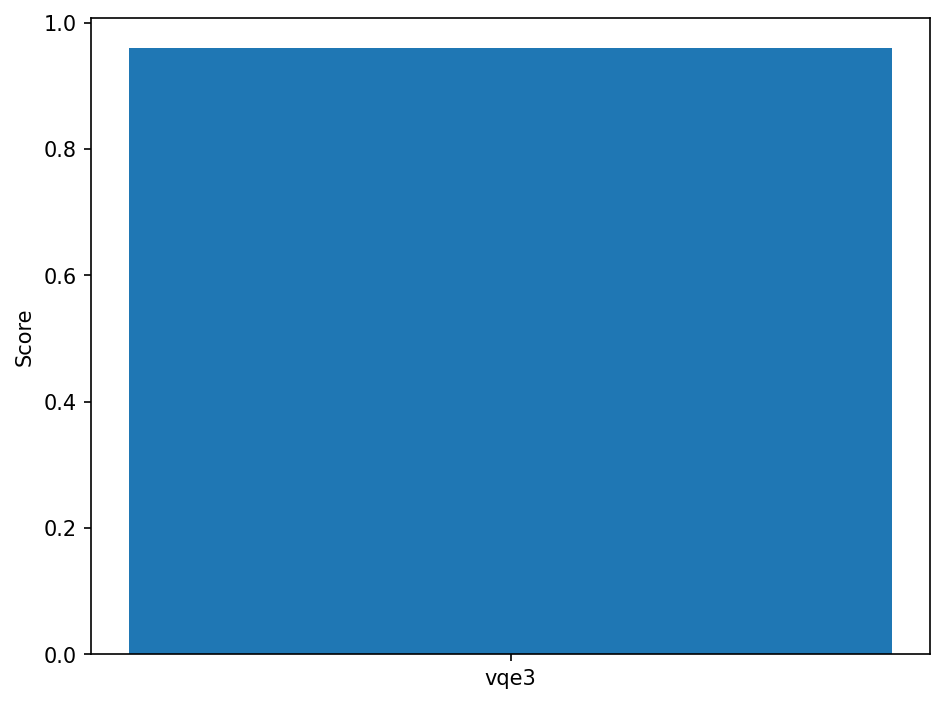

-----------------------------------------------------------
USED BACKEND:: fake_sherbrooke ; CIRCUIT_NAME: vqe4 ; SCORE = 0.9675764322414248


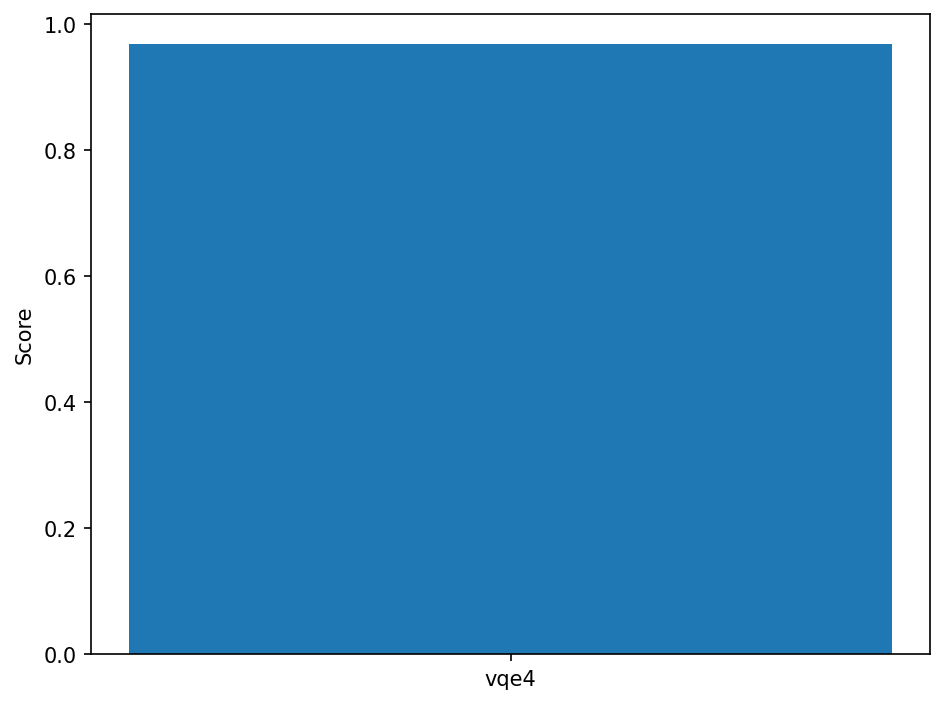

-----------------------------------------------------------


In [11]:
for label,benchmark,backend,job,score,sd in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

In [12]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
#for i,j in benchmark_features.items():
#    names.append(i)
#    scores.append(j)
#supermarq.plotting.plot_benchmark([X,names,scores],
#        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

In [13]:
#supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

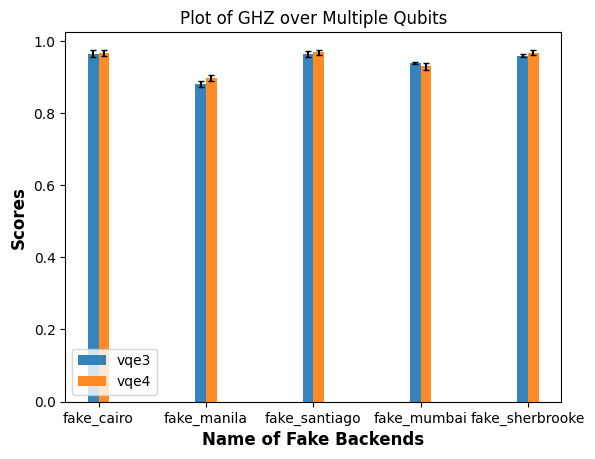

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title('Plot of GHZ over Multiple Qubits')
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()